# Ejercicios UMAP 

**Autores:**
* Jesús Martínez Leal
* Carlos Sánchez Polo

## 1. UMAP en Fashion MNIST

Primero realizaremos una reducción de dimensionalidad no supervisada mediante UMAP. Estableceremos el número de vecinos en 5 porque estamos interesados solo en la información local. Reduciremos el número de dimensiones a 2.

In [71]:
import os
import umap
import numpy as np
import seaborn as sns
from   mnist import MNIST
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from   sklearn.cluster import KMeans
from   sklearn.datasets import fetch_openml
from   sklearn.model_selection import train_test_split
from   sklearn.metrics import adjusted_mutual_info_score




In [2]:
#%matplotlib inline

sns.set_theme(style='white', context='poster')

#En la carperta Fashion-MNIST están descargado los datos
mndata = MNIST('data/fashion')

X_train, y_train = mndata.load_training()
X_test,  y_test  = mndata.load_testing()

data = np.array(np.vstack([X_train, X_test]), dtype=np.float64) / 255.0
target = np.hstack([y_train, y_test])
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

embedding1 = umap.UMAP(n_neighbors=10).fit_transform(data)

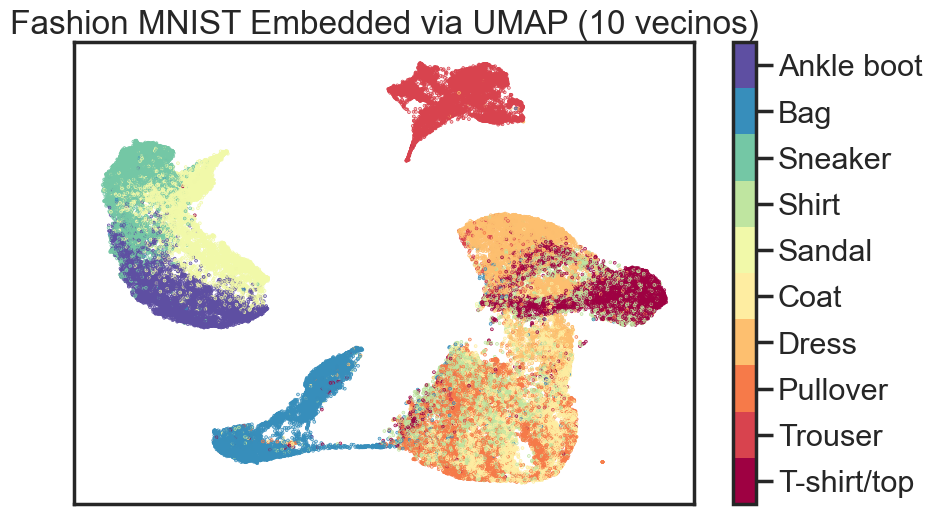

In [3]:
fig, ax = plt.subplots(1, figsize=(10, 6))
plt.scatter(*embedding1.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP (10 vecinos)');

Aplicamos DensMAP para comparar los resultados con el algoritmo UMAP clásico.

In [4]:
mapper1 = umap.UMAP(densmap=True, n_neighbors=10).fit(data)

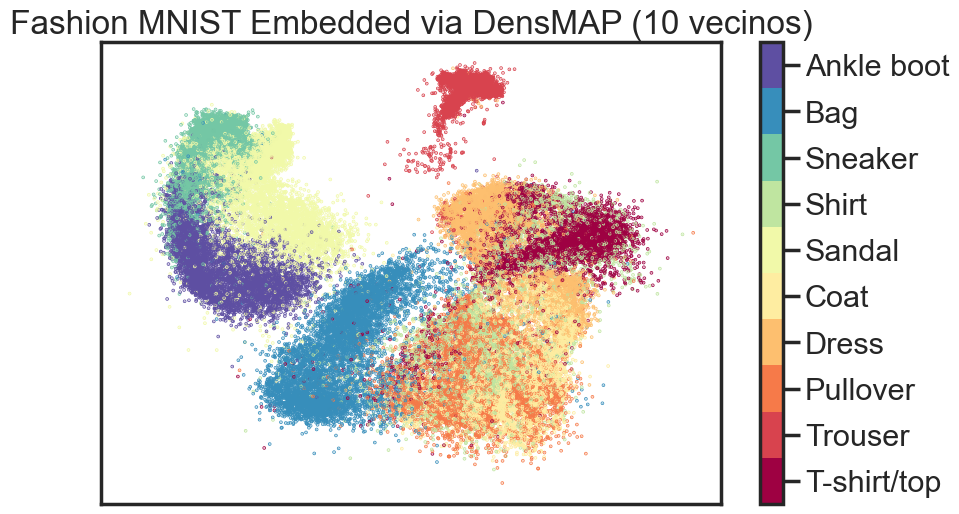

In [5]:
fig, ax = plt.subplots(1, figsize=(10, 6))
plt.scatter(*mapper1.embedding_.T, s=0.3, c=np.array(target), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via DensMAP (10 vecinos)');

## 2. Utilizando etiquetas para separar clases (Supervised UMAP)

Para realizar esta versión supervisada de UMAP introduciremos las etiquetas en el parámetro 'y' de la función 'fit' de UMAP. En este caso se utilizará un número mayor de vecinos (podemos poner 15). UMAP también permite hacer hacer aprendizaje semi-supervisado.

In [6]:
embedding2 = umap.UMAP(n_neighbors=15).fit_transform(data, y=target)

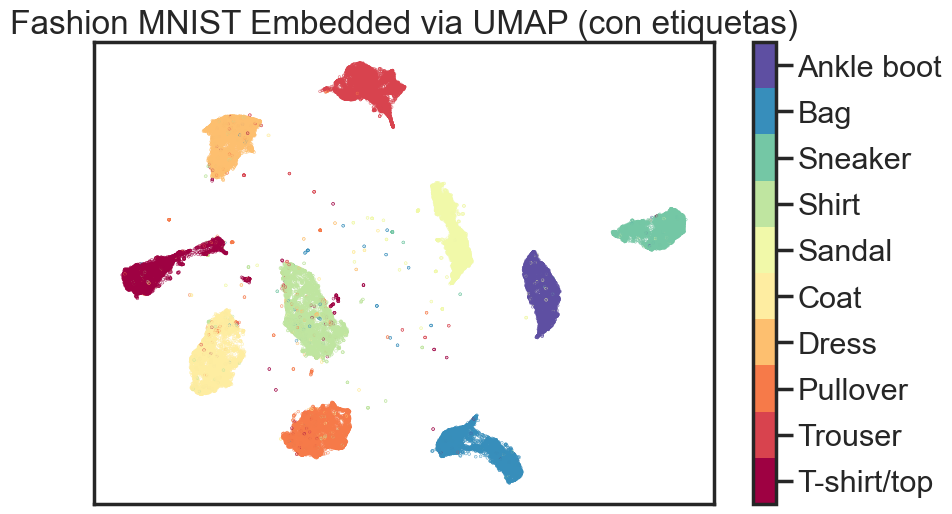

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 6))
plt.scatter(*embedding2.T, s=0.1, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP (con etiquetas)');

Aplicamos el algoritmo DensMAP para comparar con el UMAP clásico.

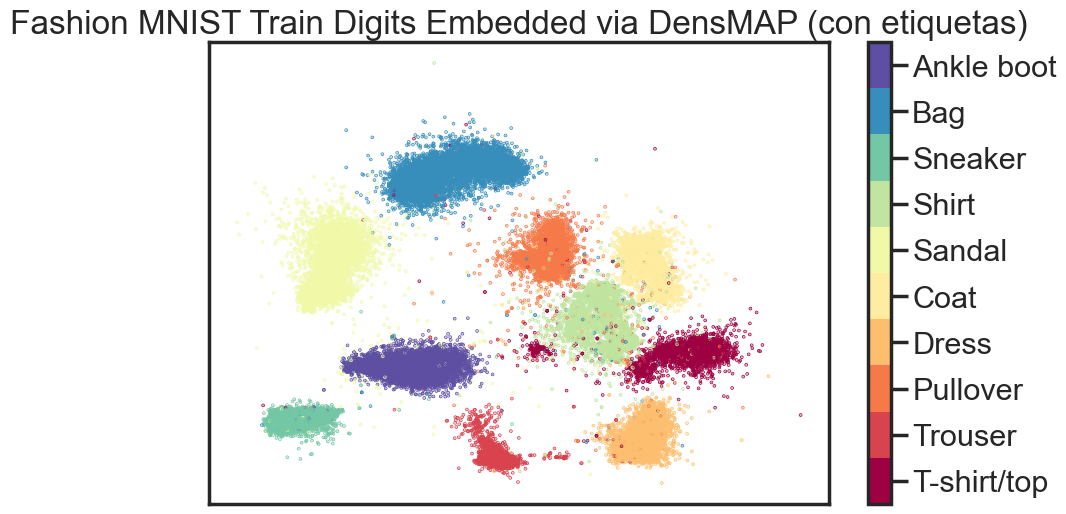

In [8]:
mapper2 = umap.UMAP(densmap=True, n_neighbors=15).fit(data, np.array(target))

fig, ax = plt.subplots(1, figsize=(10, 6))
plt.scatter(*mapper2.embedding_.T, s=0.3, c=np.array(target), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Train Digits Embedded via DensMAP (con etiquetas)');

## 3. Entrenamiento con etiquetas y embedding con test no etiquetado (Metric Learning with UMAP)

Veamos como se puede utilizar UMAP en aprendizaje métrico, es decir, aprender un embedding supervisado de los datos y utilizar datos nuevos para clasificar a partir de una métrica aprendida como una medida de la distancia entre nuevos puntos no etiquetados. Este procedimiento no lo podemos aplicar con DensMAP porque DensMAP no permite transformar datos a un "embedding" entrenado con otro dataset (train), por lo que utilizarem UMAP clásico. 

Para ello utiliza la división entre train y test proporcionada por Fashion MNIST y visualiza los resultados.

In [9]:
embedding3 = umap.UMAP(n_neighbors=15).fit_transform(X_train, y=y_train)

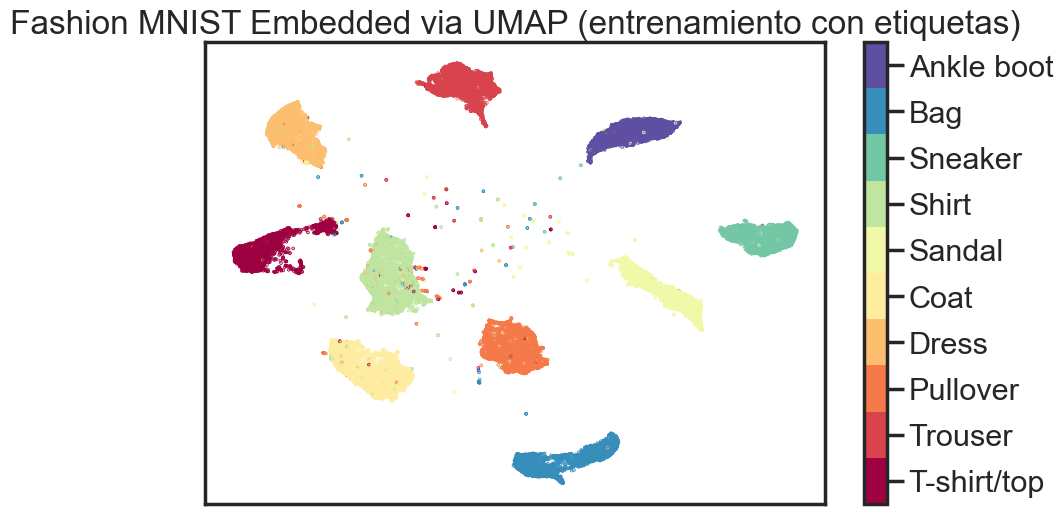

In [10]:
fig, ax = plt.subplots(1, figsize=(10, 6))
plt.scatter(*embedding3.T, s=0.3, c=y_train, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP (entrenamiento con etiquetas)');

In [11]:
umap_model = umap.UMAP(n_neighbors=15).fit(X_train, y=y_train)
embedding_test = umap_model.transform(X_test)

Text(0.5, 1.0, 'Fashion MNIST Embedded via UMAP (prueba sin etiquetas)')

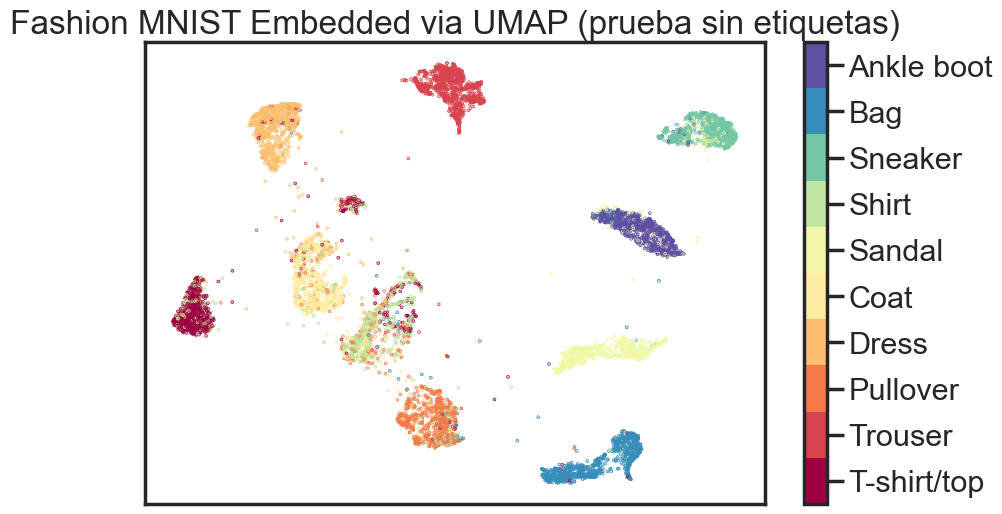

In [12]:
fig, ax = plt.subplots(1, figsize=(10, 6))
plt.scatter(*embedding_test.T, s=0.3, c=y_test, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP (prueba sin etiquetas)')

## 4. Agrupamiento (clustering)

UMAP puede utilizarse para el preprocesado de datos para mejorar el desempeño de algoritmos de clustering basados en la densidad. A pesar de que UMAP no mantiene completamente la densidad del conjunto de datos, siguen habiendo razones válidas para usar UMAP para el preprocesado previo al agrupamiento. 

1. Representa el `adjusted_mutual_info_score` en función del `número de vecinos` en el embedding (entre 4 y 10 de 2 en 2) y el `min_dist` (3 puntos entre 0 y 1).
2. Representa el resultado del embedding de la mejor combinación de parámetros.

Utiliza un K-Means con 10 clusters, ya que sabemos de antemano el número de clusters en los que se divide el conjunto de datos.

**NOTA:**

Después de seguir las instrucciones tal cual se describen arriba, llegamos a unos resultados que no nos satisfacieron en absoluto. Por eso modificamos un poco el proceso. La lista de `n_neighbors` debía ser `[4,6,8,10]` y debíamos probar además con `min_dist=[0, 0.5, 1]`. Sin embargo el modelo con mejor `adjusted_mutual_info_score` estaba muy lejos de lo esperado, por lo que decidimos no guardar solo el modelo el mayor valor del parámetro, si no que guardaríamos y representaríamos todos. Además `n_neighbors=[4,5,6,7,8,9,10]`. A continuación se pueden apreciar los 21 modelos. En la totalidad de los casos, el clustering con `k-means` se hizo con `n_clusters=10`. Se recomienda verlos. Hay más anotaciones y explicaciones tras ellos. En circunstancias normales, ejecutar el siguiente chunk requerirá **más de 10 minutos** (se podría paralelizar).

C:\Users\Carlos\AppData\Local\Temp\ipykernel_17372\2814971609.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(discrete_values))
c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


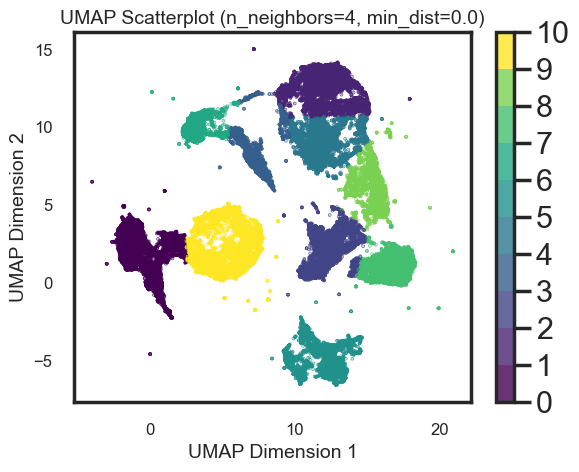

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


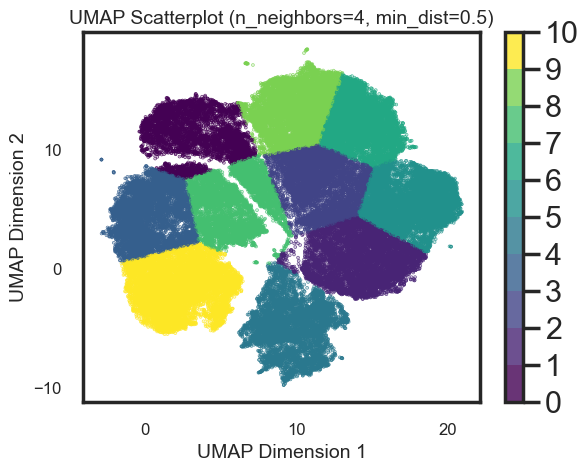

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


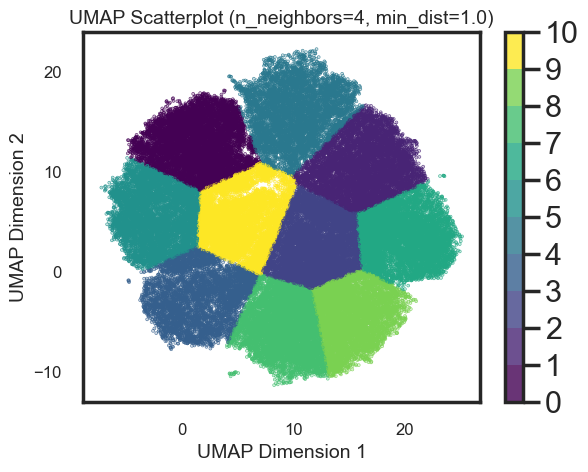

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


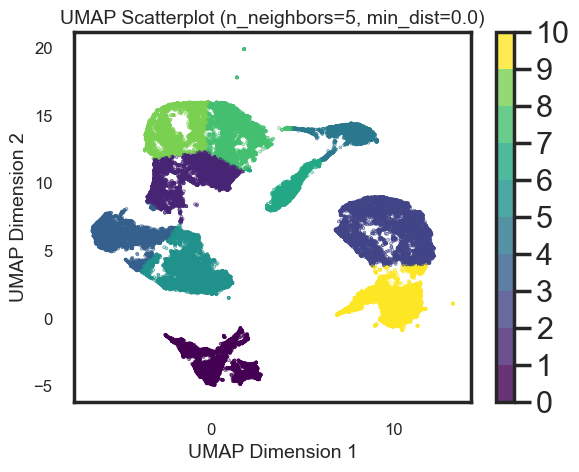

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


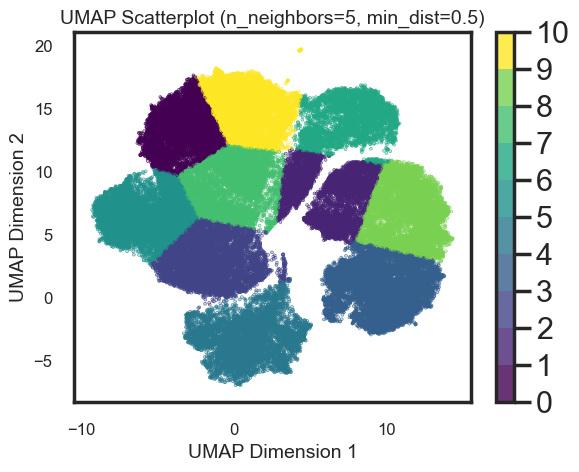

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


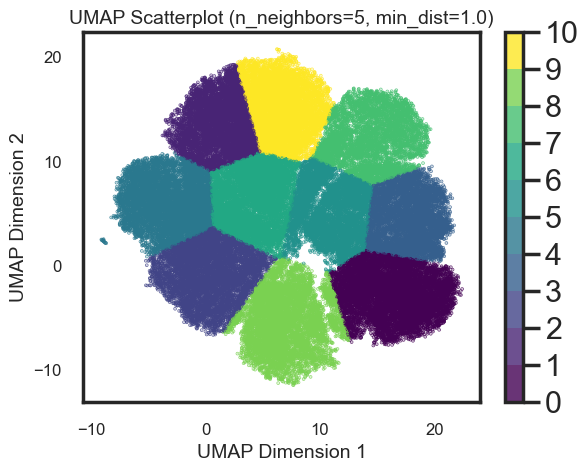

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


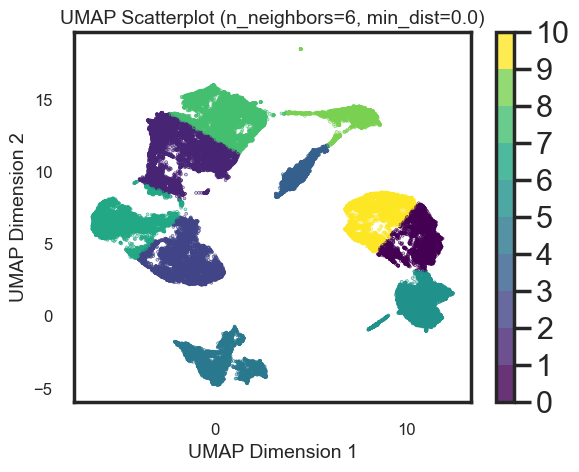

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


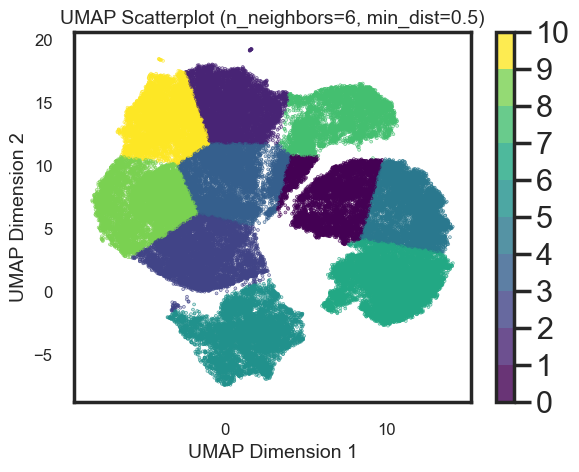

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


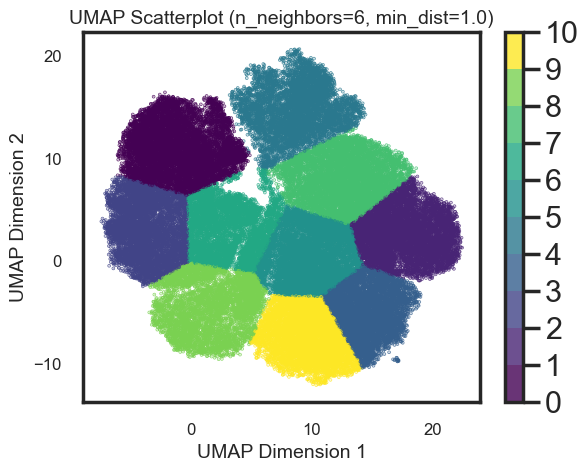

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


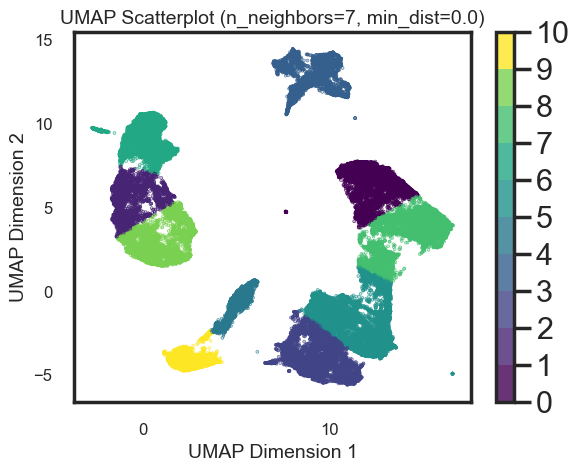

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


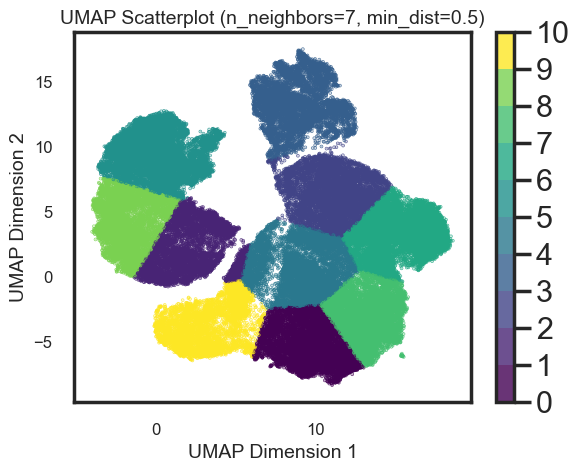

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


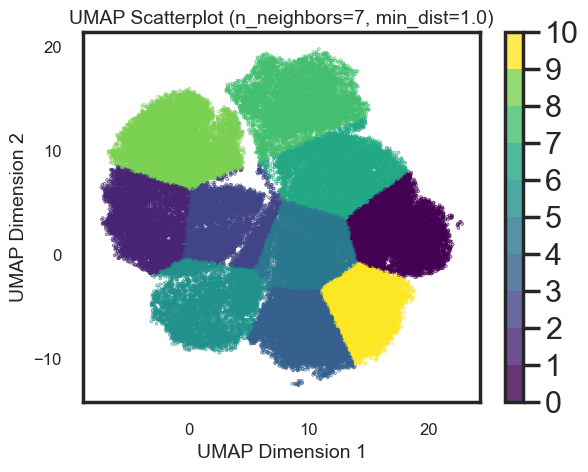

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


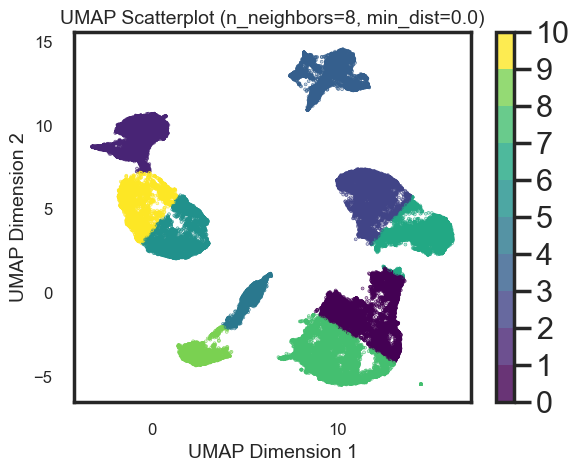

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


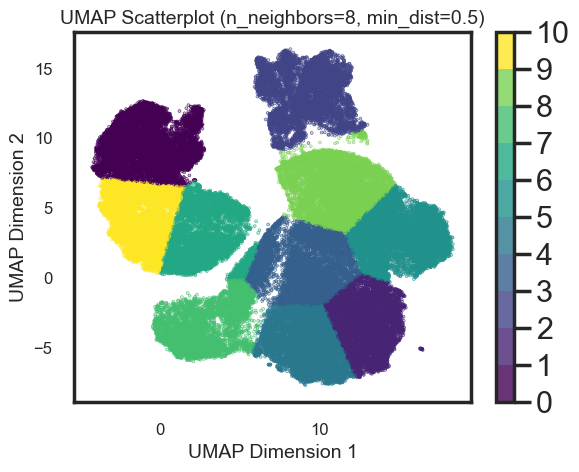

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


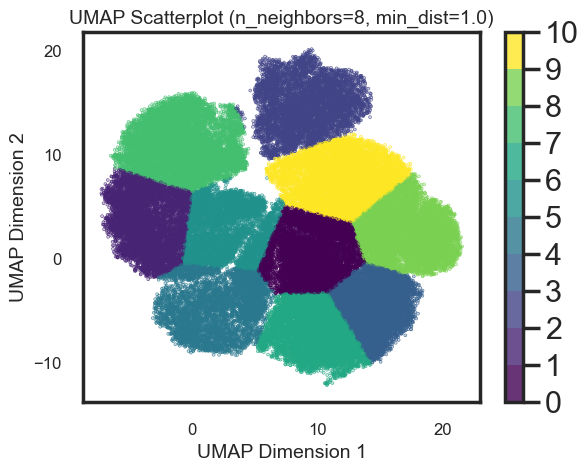

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


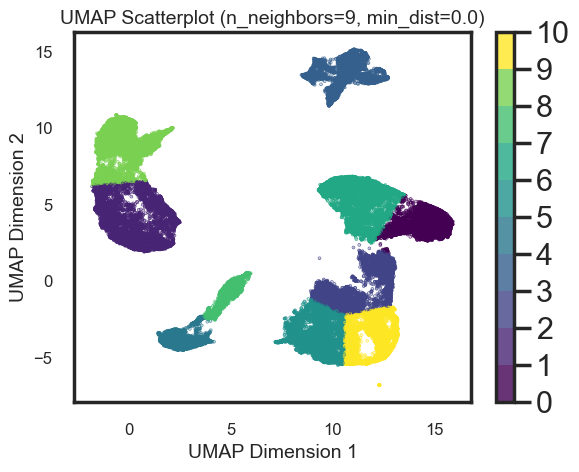

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


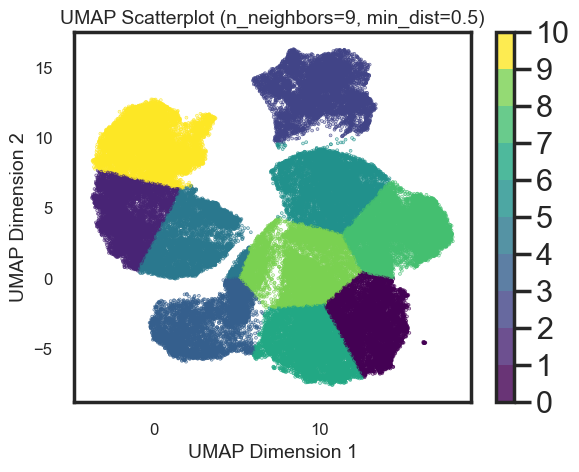

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


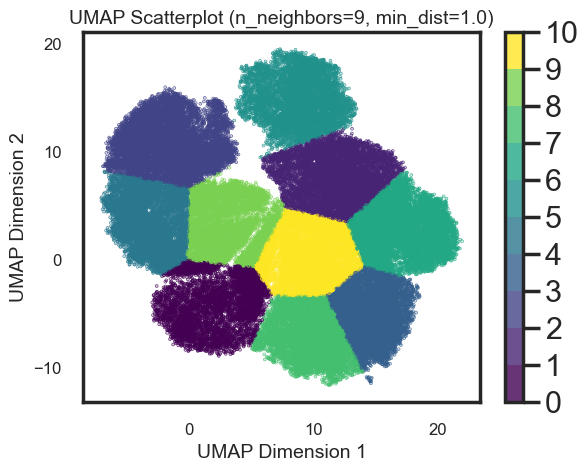

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


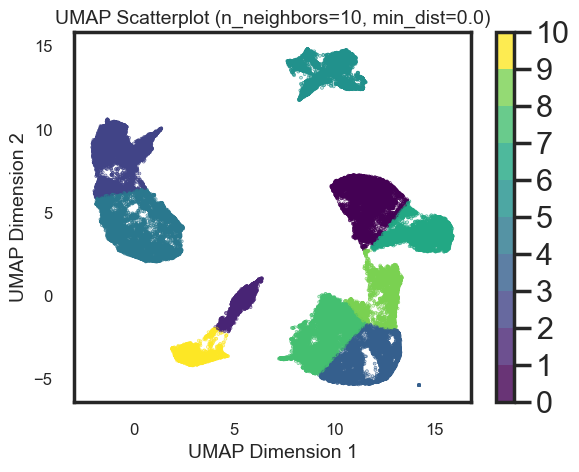

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


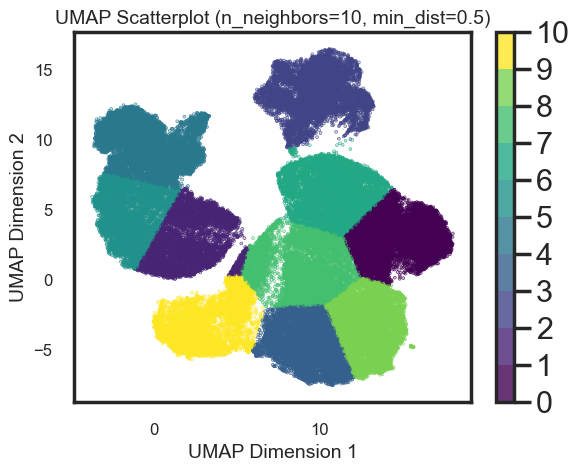

c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


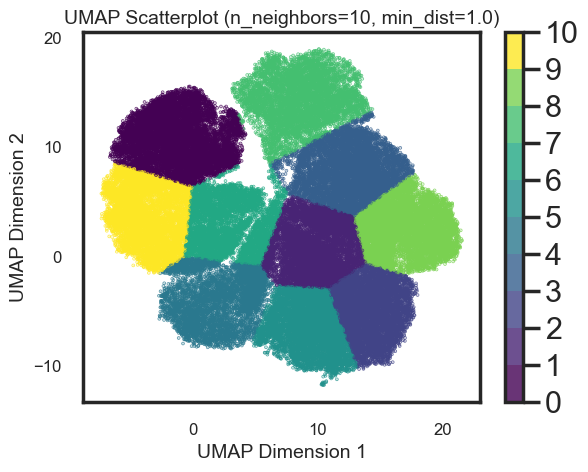

In [73]:

# Create the directory if it doesn't exist
os.makedirs('data/plots', exist_ok=True)


# Define the range of parameters
n_neighbors_range = range(4, 11, 1)
min_dist_range = np.linspace(0, 1, 3)

# Initialize variables to store the best parameters and score
best_score = -1
best_n_neighbors = None
best_min_dist = None

discrete_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Create a colormap with the desired number of colors
cmap = plt.cm.get_cmap('viridis', len(discrete_values))

# Initialize lists to store the scores and parameter combinations
scores = []
param_combinations = []

# Initialize dictionary to store the models
models = {}


# Iterate over the parameter combinations
for n_neighbors in n_neighbors_range:
    for min_dist in min_dist_range:
        # Perform UMAP embedding with the current parameters
        umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
        embedding = umap_model.fit_transform(data)
        
        # Perform K-Means clustering on the embedded data
        kmeans = KMeans(n_clusters=10)
        labels = kmeans.fit_predict(embedding)
        
        # Calculate the adjusted mutual information score
        score = adjusted_mutual_info_score(target, labels)
        
        # Store the score and parameter combination
        scores.append(score)
        param_combinations.append((n_neighbors, min_dist))
        
        # Update the best score and parameters if necessary
        if score > best_score:
            best_score = score
            best_n_neighbors = n_neighbors
            best_min_dist = min_dist
        
        # Store the model
        model_name = f"param_combinations_{n_neighbors}_{min_dist}"
        models[model_name] = umap_model
        
        # Create a boundary norm to discretize the color bar
        norm = mcolors.BoundaryNorm(discrete_values, cmap.N)
        cbar.ax.tick_params(labelsize=10)
        
        # Plot the scatter plot with the discretized color bar
        plt.scatter(embedding[:, 0], embedding[:, 1], s=0.3, c=labels, cmap=cmap, norm=norm, alpha=0.8)
        plt.colorbar(ticks=discrete_values)
        plt.title(f"UMAP Scatterplot (n_neighbors={n_neighbors}, min_dist={min_dist})", fontsize=14)
        plt.xlabel('UMAP Dimension 1', fontsize=14)
        plt.ylabel('UMAP Dimension 2', fontsize=14)
        plt.xticks(size=12)
        plt.yticks(size=12)
        
        # Save the plot
        plot_name = f"UMAP Scatterplot (n_neighbors={n_neighbors}, min_dist={min_dist})"
        plt.savefig(f"data/plots/{plot_name}.png")
        
        # Show the plot
        plt.show()


A continuación mostramos como varía el `Adjusted Mutual Information Score (AMIS)` según los parámetros `n_neighbors` y `min_dist`. El test afirma que aquellos parámetros con `min_dist=0` son los mejores (o almenos los que disponen de un mayor `AMIS`). Sin embargo son aquellos que muestran un peor embeding UMAP. Eso es lo que nos desconcertó en un primer momento y lo que nos hizo variar nuestra metodología.

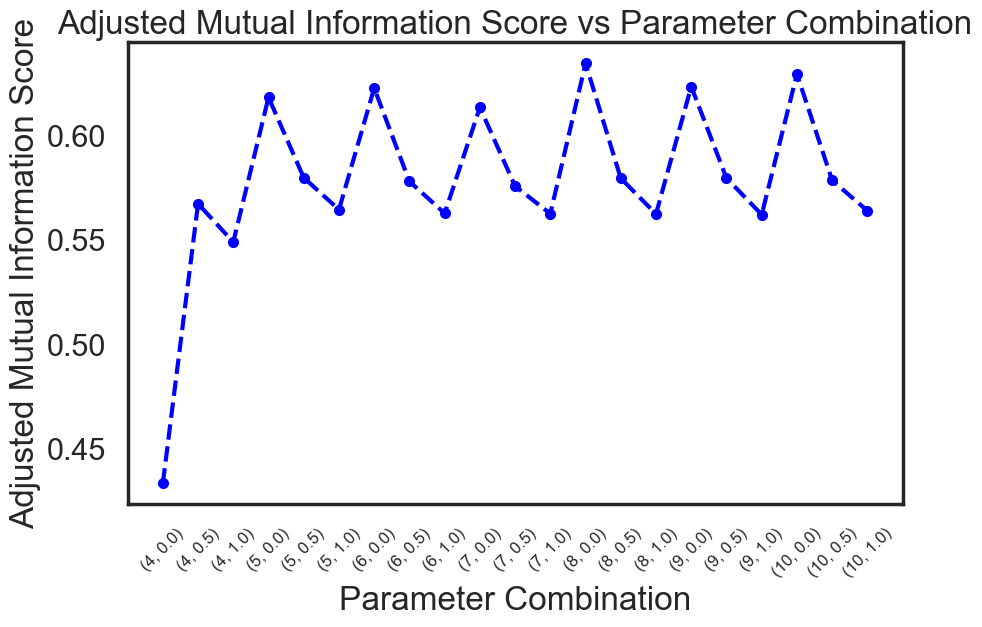

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(scores, linestyle='--', color='blue', marker='o', markersize=7)
plt.xlabel('Parameter Combination')
plt.ylabel('Adjusted Mutual Information Score')
plt.title('Adjusted Mutual Information Score vs Parameter Combination')
plt.xticks(range(len(param_combinations)), param_combinations, rotation=45, size=12)
plt.show()


A continuación mostramos lo que estamos repitiendo, que el mejor modelo según `AMIS` no es el que mejor se ajusta a la realidad.

In [63]:
# Perform UMAP embedding with the best parameters
best_umap_model = umap.UMAP(n_neighbors=best_n_neighbors, min_dist=best_min_dist)
best_embedding = best_umap_model.fit_transform(data)

# Perform K-Means clustering on the embedded data
kmeans = KMeans(n_clusters=10)
best_labels = kmeans.fit_predict(best_embedding)
best_labels_cat = [str(i) for i in best_labels]


c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


C:\Users\Carlos\AppData\Local\Temp\ipykernel_17372\4155962315.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(discrete_values))


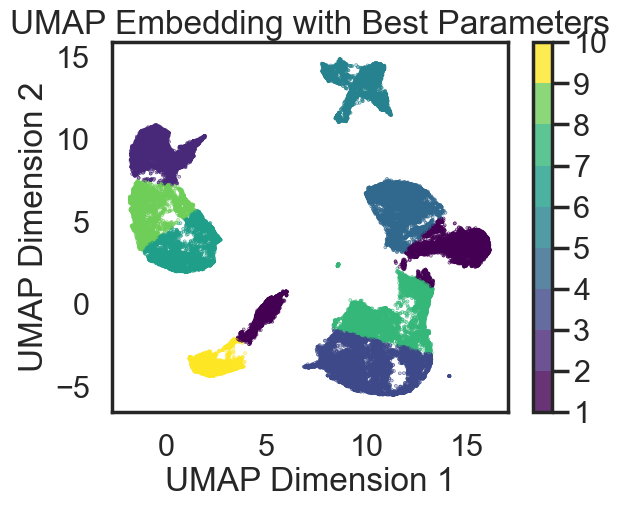

In [65]:
# Create a list of discrete values for the color bar
discrete_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Create a colormap with the desired number of colors
cmap = plt.cm.get_cmap('viridis', len(discrete_values))

# Create a boundary norm to discretize the color bar
norm = mcolors.BoundaryNorm(discrete_values, cmap.N)

# Plot the scatter plot with the discretized color bar
plt.scatter(best_embedding[:, 0], best_embedding[:, 1], s=0.3, c=best_labels, cmap=cmap, norm=norm, alpha=0.8)
plt.colorbar(ticks=discrete_values)
plt.title('UMAP Embedding with Best Parameters')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

Podemos ordenar los modelos según su valor de Score. El que está representado en el chunk anterior es el que usa `n_neighbors=8` y `min_dist=0`, cuando a nuestro juicio el mejor es `n_neighbors=5` y `min_dist=1`.

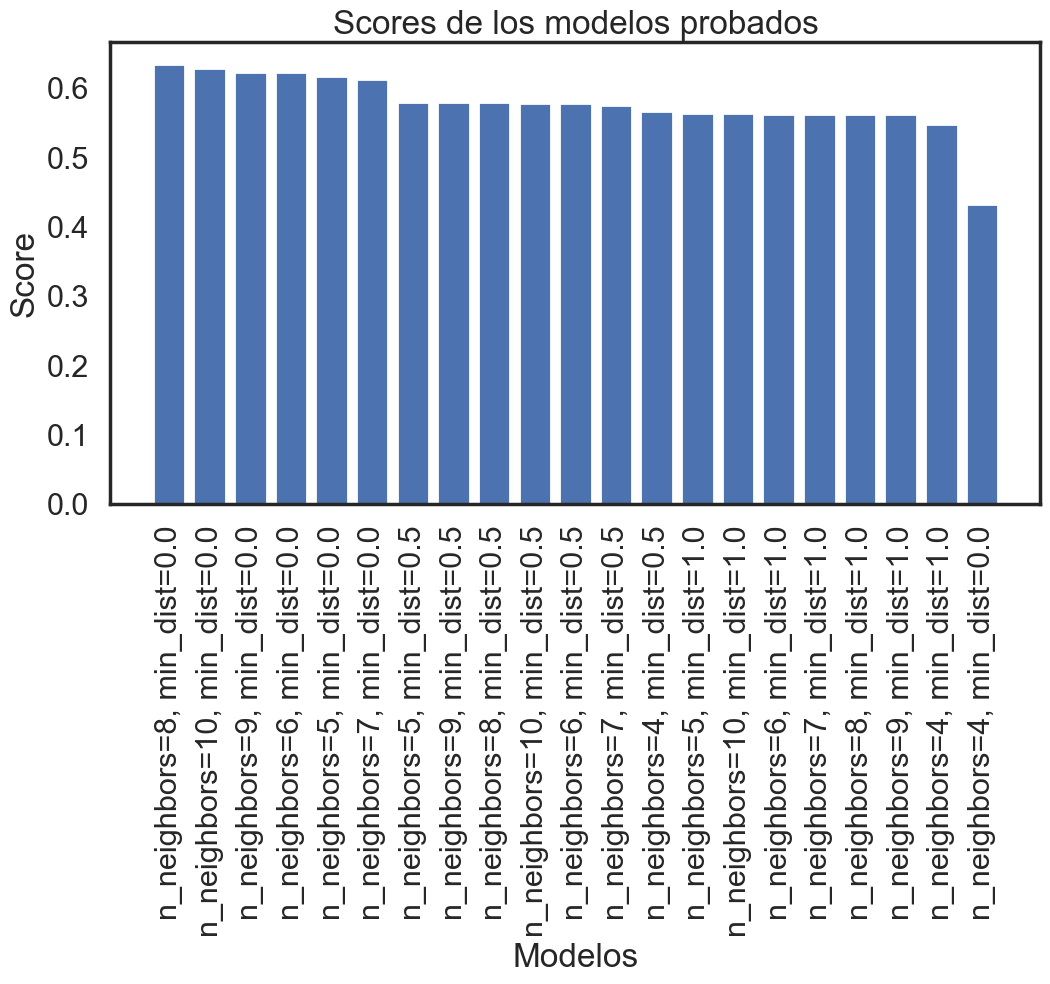

In [64]:


# Obtener los parámetros y scores de todos los modelos
param_scores = [(n_neighbors, min_dist, score) for (n_neighbors, min_dist), score in zip(param_combinations, scores)]

# Ordenar los modelos por score de mayor a menor
param_scores.sort(key=lambda x: x[2], reverse=True)

# Obtener los valores de los parámetros y scores
param_values = [f"n_neighbors={n_neighbors}, min_dist={min_dist}" for n_neighbors, min_dist, _ in param_scores]
score_values = [score for _, _, score in param_scores]

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(param_values, score_values)
plt.xticks(rotation=90)
plt.xlabel('Modelos')
plt.ylabel('Score')
plt.title('Scores de los modelos probados')
plt.show()


In [68]:
real_best_umap_model = umap.UMAP(n_neighbors=5, min_dist=1.0)
embedding = real_best_umap_model.fit_transform(data)
        
# Perform K-Means clustering on the embedded data
kmeans = KMeans(n_clusters=10)
labels = kmeans.fit_predict(embedding)


c:\Users\Carlos\anaconda3\envs\Intro_CD_23_24\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


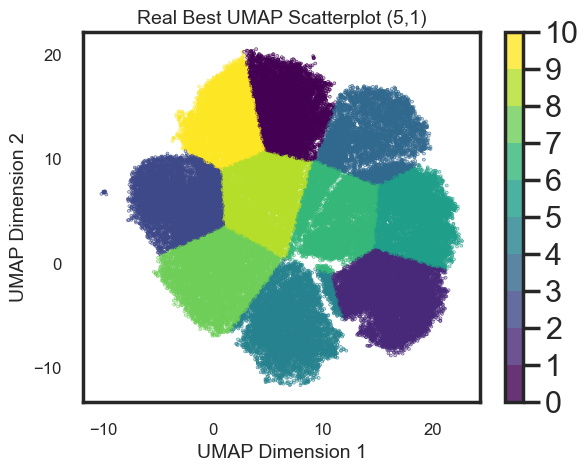

In [70]:
discrete_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Create a boundary norm to discretize the color bar
norm = mcolors.BoundaryNorm(discrete_values, cmap.N)
cbar.ax.tick_params(labelsize=10)

# Plot the scatter plot with the discretized color bar
plt.scatter(embedding[:, 0], embedding[:, 1], s=0.3, c=labels, cmap=cmap, norm=norm, alpha=0.8)
plt.colorbar(ticks=discrete_values)
plt.title(f"Real Best UMAP Scatterplot ({n_neighbors},{min_dist})", fontsize=14)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

Se pueden consultar todos los plots en /data/plots/